In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes
import gower
from sklearn.metrics import silhouette_score

In [3]:
df = pd.read_csv("Melbourne_housing_CLEANED.csv")

In [4]:
num_cols = ["Price", "Rooms", "Bathroom", "Car", "Landsize", "BuildingArea", "Distance"]
cat_cols = ["Type", "Regionname"]

df_sel = df[num_cols + cat_cols].copy()

In [5]:
df_sel["RegionGroup"] = df_sel["Regionname"].replace({
    "Northern Metropolitan": "Metro",
    "Southern Metropolitan": "Metro",
    "Eastern Metropolitan": "Metro",
    "Western Metropolitan": "Metro",
    "South-Eastern Metropolitan": "Metro",
    "Northern Victoria": "Regional",
    "Eastern Victoria": "Regional",
    "Western Victoria": "Regional"
})

df_sel = df_sel.drop(columns=["Regionname"])

In [6]:
scaler = StandardScaler()
num_scaled = scaler.fit_transform(df_sel[num_cols])

df_scaled = pd.DataFrame(num_scaled, columns=num_cols)


for col in ["Type", "RegionGroup"]:
    df_scaled[col] = df_sel[col].values

df_scaled = df_scaled[num_cols + ["Type", "RegionGroup"]]

In [7]:
k = 3
cat_indices = [df_scaled.columns.get_loc("Type"), df_scaled.columns.get_loc("RegionGroup")]

kproto = KPrototypes(n_clusters=k, init='Cao', random_state=42, n_jobs=-1)
clusters = kproto.fit_predict(df_scaled.values, categorical=cat_indices)

df_scaled["segment"] = clusters
df_sel["segment"] = clusters

In [12]:
df_sample = df_scaled.sample(3000, random_state=42)
gower_dist = gower.gower_matrix(df_sample)

In [13]:
sil_score = silhouette_score(gower_dist, df_sample["segment"], metric="precomputed")

print("Silhouette score:", sil_score)

Silhouette score: 0.41715756


In [19]:
tier_mapping = {
    2: "S",   # Luxury properties
    1: "A",   # Family homes
    0: "B"    # Affordable properties
}

df_sel["Tier"] = df_sel["segment"].map(tier_mapping)

In [20]:
df_sel.head(10)

,Price,Rooms,Bathroom,Car,Landsize,BuildingArea,Distance,Type,RegionGroup,segment,Tier
0,1480000.0,2,1,1,202.0,140.0,2.5,h,Metro,0,B
1,1035000.0,2,1,0,156.0,79.0,2.5,h,Metro,0,B
2,1465000.0,3,2,0,134.0,150.0,2.5,h,Metro,0,B
3,850000.0,3,2,1,94.0,140.0,2.5,h,Metro,0,B
4,1600000.0,4,1,2,120.0,142.0,2.5,h,Metro,0,B
5,941000.0,2,1,0,181.0,140.0,2.5,h,Metro,0,B
6,1876000.0,3,2,0,245.0,210.0,2.5,h,Metro,2,S
7,1636000.0,2,1,2,256.0,107.0,2.5,h,Metro,0,B
8,300000.0,1,1,1,0.0,75.0,2.5,u,Metro,0,B
9,1097000.0,2,1,2,220.0,75.0,2.5,h,Metro,0,B


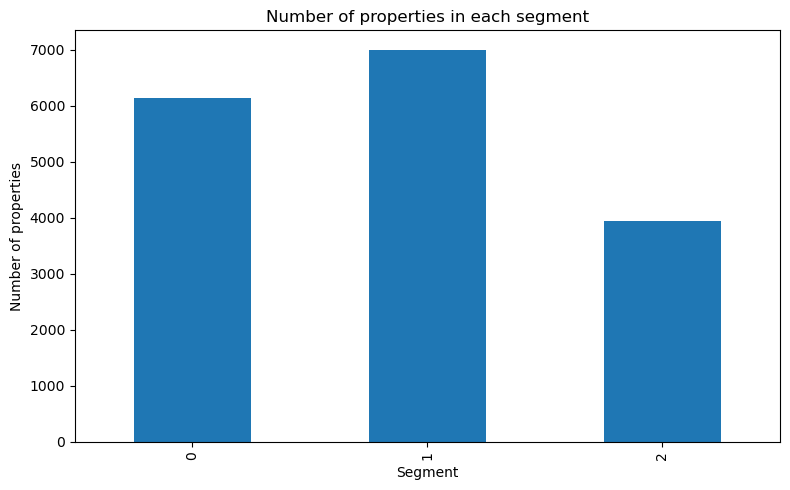

In [14]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 5)


segment_counts = df_sel["segment"].value_counts().sort_index()

plt.figure()
segment_counts.plot(kind="bar")
plt.xlabel("Segment")
plt.ylabel("Number of properties")
plt.title("Number of properties in each segment")
plt.tight_layout()
plt.show()

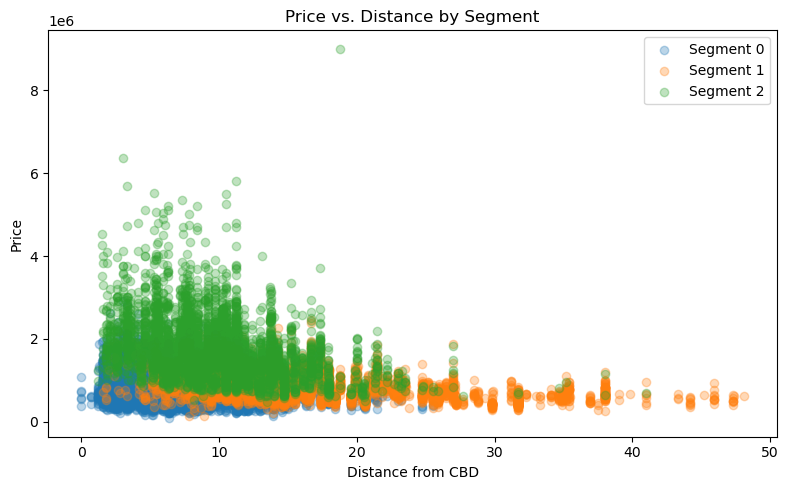

In [16]:
plt.figure()
for seg in sorted(df_sel["segment"].unique()):
    subset = df_sel[df_sel["segment"] == seg]
    plt.scatter(subset["Distance"], subset["Price"], alpha=0.3, label=f"Segment {seg}")

plt.xlabel("Distance from CBD")
plt.ylabel("Price")
plt.title("Price vs. Distance by Segment")
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
print(df_sel.columns)

Index(['Price', 'Rooms', 'Bathroom', 'Car', 'Landsize', 'BuildingArea',
       'Distance', 'Type', 'RegionGroup', 'segment'],
      dtype='object')


<Figure size 800x500 with 0 Axes>

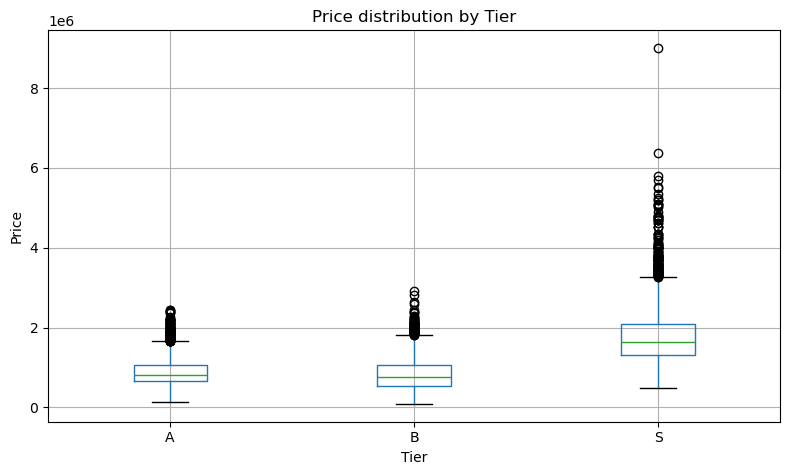

In [21]:
plt.figure()
df_sel.boxplot(column="Price", by="Tier")
plt.title("Price distribution by Tier")
plt.suptitle("") 
plt.xlabel("Tier")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

In [22]:
segment_summary = df_sel.groupby("segment")[num_cols].mean().round(2)
print("\n=== Segment numeric summary (means) ===")
print(segment_summary)


tier_summary = df_sel.groupby("Tier")[num_cols].mean().round(2)
print("\n=== Tier numeric summary (means) ===")
print(tier_summary)


=== Segment numeric summary (means) ===
              Price  Rooms  Bathroom   Car  Landsize  BuildingArea  Distance
segment                                                                     
0         832860.03   2.26      1.20  1.07    186.66        101.33      7.06
1         888221.46   3.19      1.44  2.00    605.29        137.89     15.48
2        1755616.77   3.92      2.28  2.10    559.23        174.37      9.64

=== Tier numeric summary (means) ===
           Price  Rooms  Bathroom   Car  Landsize  BuildingArea  Distance
Tier                                                                     
A      888221.46   3.19      1.44  2.00    605.29        137.89     15.48
B      832860.03   2.26      1.20  1.07    186.66        101.33      7.06
S     1755616.77   3.92      2.28  2.10    559.23        174.37      9.64
